In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("MDA2 - Group Assignment - EDA")
    .getOrCreate())


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Import Parquet Data


In [4]:
import pandas as pd
import pandas as pd
import glob


from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType, IntegerType
biketrips_weather_total = spark.read.parquet("hdfs://localhost:9000/datalake/std/bikes_sharing")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
biketrips_weather_total.cache()

DataFrame[start_date: date, : int, ride_id: string, rideable_type: string, start_station_name: string, start_station_id: float, end_station_name: string, end_station_id: float, start_lat: float, start_lng: float, end_lat: float, end_lng: float, member_casual: string, started_at: timestamp, ended_at: timestamp, duration: bigint, tempmax: double, tempmin: double, temp: double, feelslikemax: double, feelslikemin: double, feelslike: double, dew: double, humidity: double, precip: double, precipprob: int, precipcover: double, snow: double, snowdepth: double, windspeed: double, winddir: double, sealevelpressure: double, cloudcover: double, visibility: double, solarradiation: double, solarenergy: double, uvindex: int, sunrise: timestamp, sunset: timestamp, moonphase: double, sunlight_hours: double]

In [5]:
biketrips_weather_total.show(5)

+----------+---+----------------+-------------+--------------------+----------------+--------------------+--------------+---------+---------+--------+---------+-------------+-------------------+-------------------+--------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+-------------------+-------------------+---------+--------------+
|start_date|   |         ride_id|rideable_type|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat|start_lng| end_lat|  end_lng|member_casual|         started_at|           ended_at|duration|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|            sunrise|             sunset|moonphase|sunlight_hours|
+-----

In [7]:
biketrips_weather_total.columns

['start_date',
 '',
 'ride_id',
 'rideable_type',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'started_at',
 'ended_at',
 'duration',
 'tempmax',
 'tempmin',
 'temp',
 'feelslikemax',
 'feelslikemin',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'precipcover',
 'snow',
 'snowdepth',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'sunrise',
 'sunset',
 'moonphase',
 'sunlight_hours']

In [15]:
# Shape of df
print((biketrips_weather_total.count(), len(biketrips_weather_total.columns)))

(10214972, 41)


In [21]:
biketrips_weather_total.describe().show()


+-------+------------------+----------------+-------------+--------------------+------------------+--------------------+-----------------+-------------------+--------------------+--------------------+-------------------+-------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|                  |         ride_id|rideable_type|  start_station_name|  start_station_id|    end_station_name|   end_station_id|          start_lat|           start_lng|             end_lat|            end_lng|member_casual|          duration|          tempmax|           tempmin|              tem

# Total Rides vs Sunlight Hours

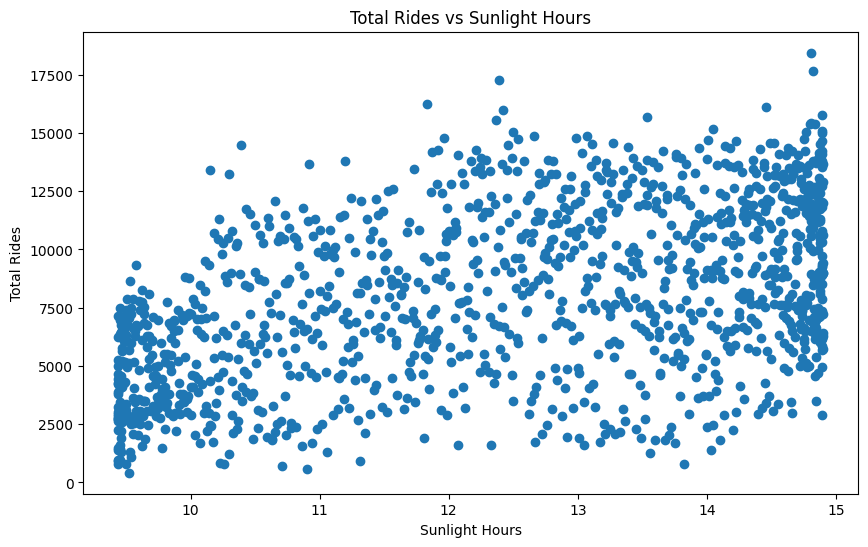

In [14]:
from pyspark.sql.functions import count, avg
# Group by 'start_date' and calculate total rides and average sunlight hours
aggregated_data = biketrips_weather_total.groupBy("start_date").agg(
    count("ride_id").alias("total_rides"),
    avg("sunlight_hours").alias("average_sunlight_hours")
)
plot_data = aggregated_data.collect()
# Extracting x and y values for plotting
x_values = [row['average_sunlight_hours'] for row in plot_data]
y_values = [row['total_rides'] for row in plot_data]

# Plotting the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values)
plt.title('Total Rides vs Sunlight Hours')
plt.xlabel('Sunlight Hours')
plt.ylabel('Total Rides')
plt.show()


The scatter plot shows a wide distribution of total bike rides across varying amounts of sunlight hours, with no clear trend indicating a direct correlation.

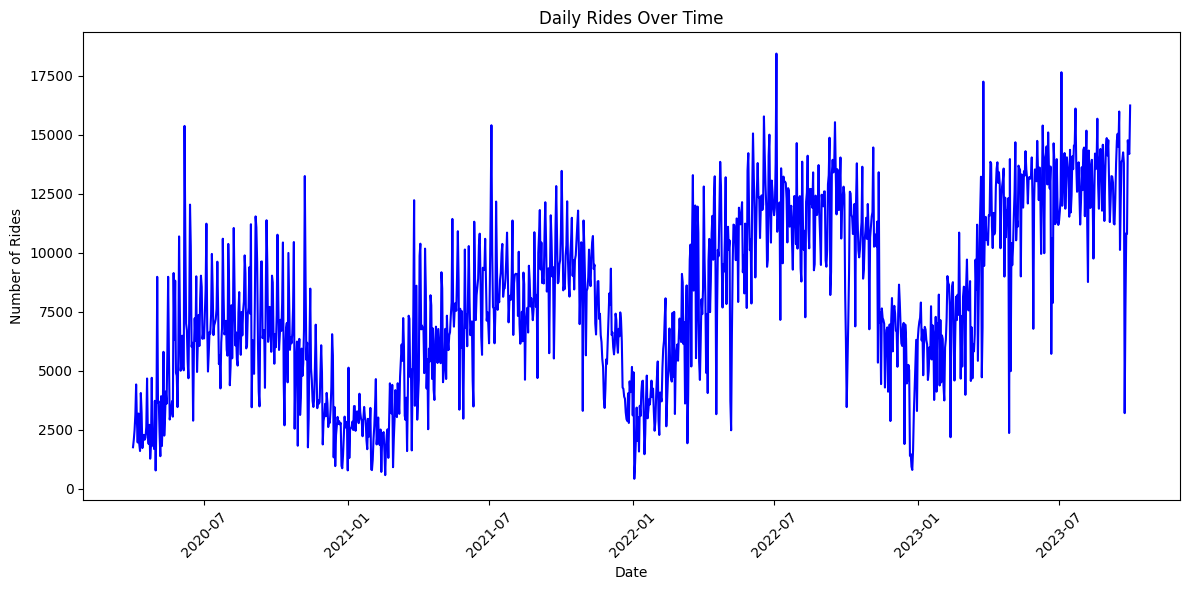

In [17]:
# Group by 'start_date' and count the number of rides
daily_rides = biketrips_weather_total.groupBy("start_date").count().orderBy("start_date")
daily_rides_data = daily_rides.collect()
# Extract dates and counts for plotting
dates = [row['start_date'] for row in daily_rides_data]
counts = [row['count'] for row in daily_rides_data]

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(dates, counts, linestyle='-', color='b')
plt.title('Daily Rides Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to fit all elements
plt.show()


In this graph we can observe the clear pattern that seasonality is key in our data. The colder the month, the fewer bicycle trips.

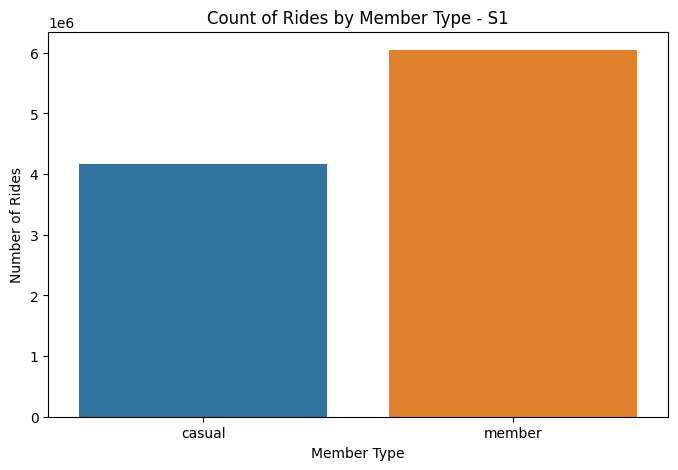

In [19]:
member_counts_s1 = biketrips_weather_total.groupBy("member_casual").count().toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="member_casual", y="count", data=member_counts_s1)
plt.title("Count of Rides by Member Type - S1")
plt.xlabel("Member Type")
plt.ylabel("Number of Rides")
plt.show()



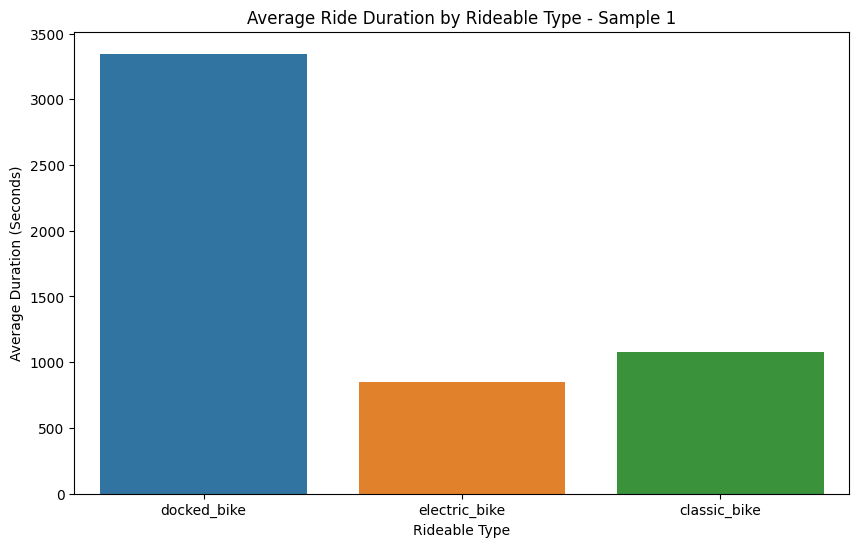

In [20]:
avg_duration_by_type_s1 = biketrips_weather_total.groupBy("rideable_type").mean("duration").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="rideable_type", y="avg(duration)", data=avg_duration_by_type_s1)
plt.title("Average Ride Duration by Rideable Type - Sample 1")
plt.xlabel("Rideable Type")
plt.ylabel("Average Duration (Seconds)")
plt.show()


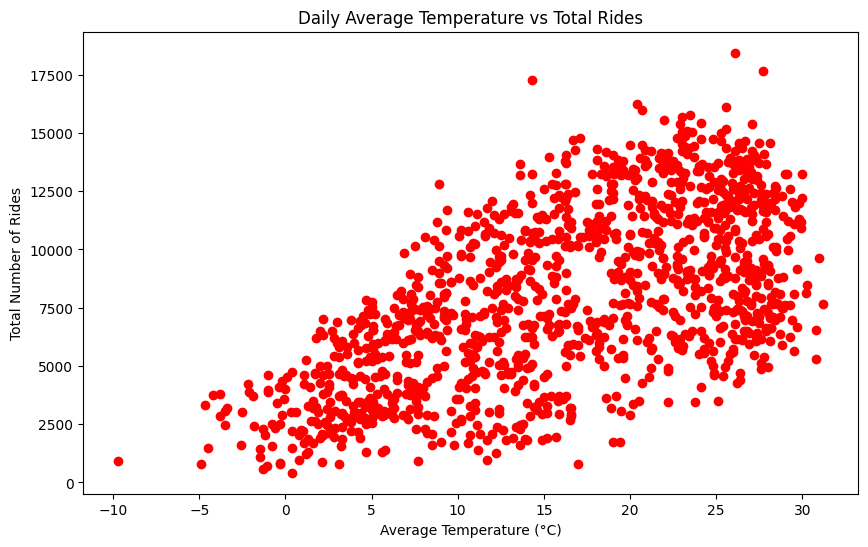

In [22]:
from pyspark.sql.functions import to_date, avg, count

# Assuming 'temp' is the temperature column and 'started_at' contains the timestamp of each ride
daily_temp_rides = biketrips_weather_total.withColumn("date", to_date("started_at")) \
                            .groupBy("date") \
                            .agg(avg("temp").alias("avg_temp"),
                                 count("ride_id").alias("total_rides"))
temp_rides_data = daily_temp_rides.collect()
# Extract the temperature and ride counts
temps = [row['avg_temp'] for row in temp_rides_data]
ride_counts = [row['total_rides'] for row in temp_rides_data]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(temps, ride_counts, color='r')
plt.title('Daily Average Temperature vs Total Rides')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Number of Rides')
plt.show()

The scatter plot illustrates a general trend where the total number of bike rides increases with the average daily temperature, indicating that warmer days tend to be associated with higher bike usage, with the most rides occurring at moderate temperatures.

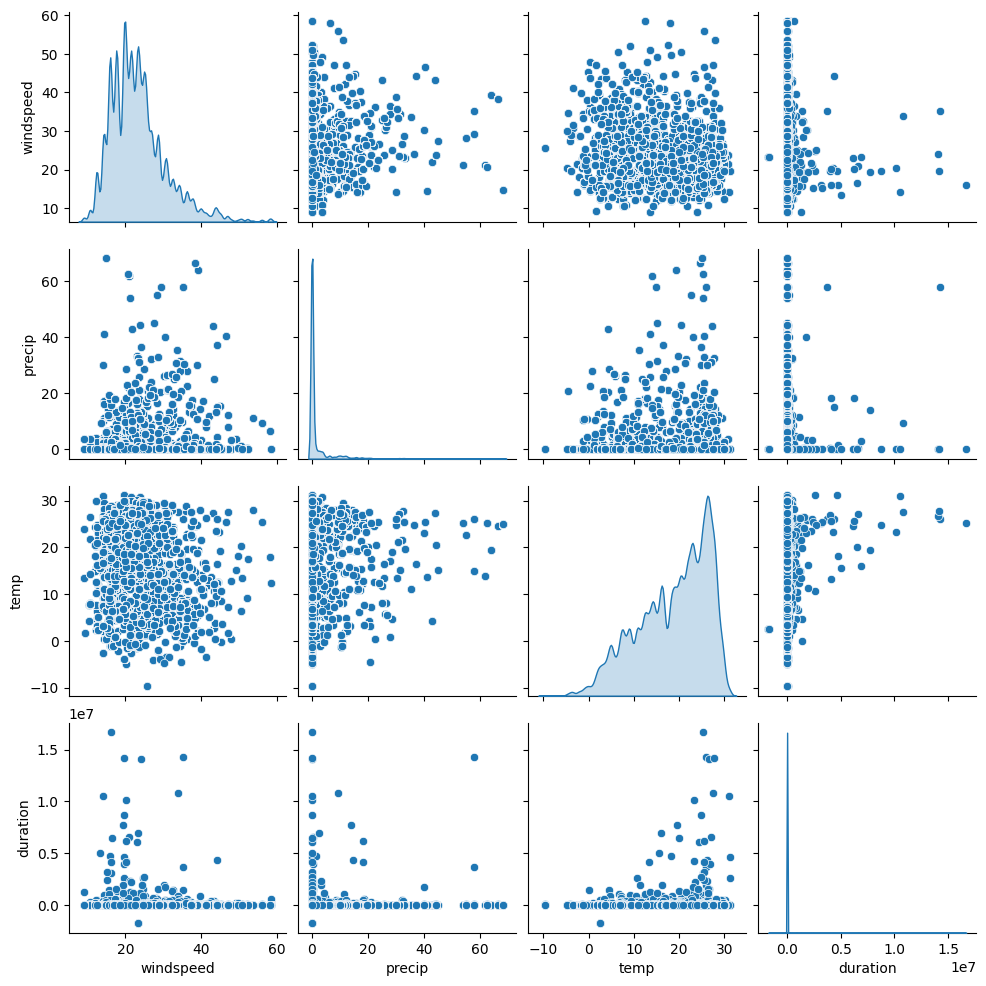

In [27]:
# Select only the relevant columns
selected_data = biketrips_weather_total.select("windspeed", "precip", "temp", "duration")
# Collect a sample of the data to avoid overloading the driver node
sample_data = selected_data.sample(fraction=0.1).toPandas()  # Adjust the fraction as needed
import seaborn as sns

# Use Seaborn's pairplot function to create a pair plot
sns.pairplot(sample_data, diag_kind='kde')
plt.show()


In this graph we are going to focus on the last line. It is clear from the 3 graphs that days with less precipitation have more rides. The less precipitation, the more bikes ride. And the same with temperature. Hotter days lead to more bike rides.

In [29]:
from pyspark.mllib.stat import Statistics
import numpy as np

# Select only the numerical columns for the correlation matrix
numerical_data = biketrips_weather_total.select("temp", "windspeed", "precip", "duration")

# Convert to RDD and compute correlation matrix
rdd = numerical_data.rdd.map(lambda row: np.array([row['temp'], row['windspeed'], row['precip'], row['duration']]))
correlation_matrix = Statistics.corr(rdd, method="pearson")

# Convert the correlation matrix to a DataFrame for better visualization
col_names = ["temp", "windspeed", "precip", "duration"]
corr_df = spark.createDataFrame(correlation_matrix.tolist(), col_names)


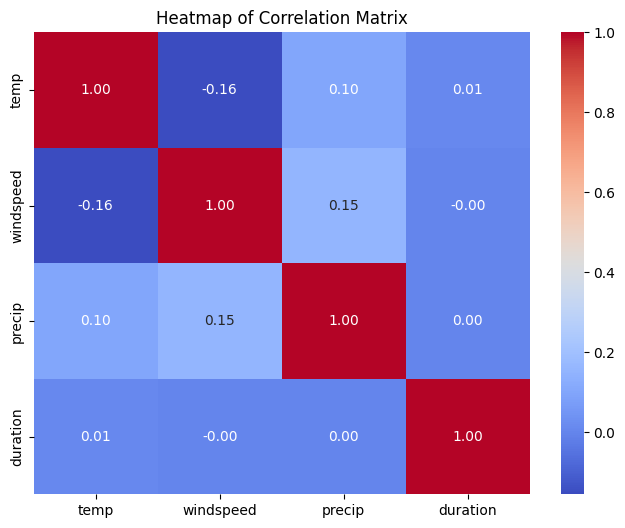

In [30]:
# Collect the correlation matrix to the driver
corr_data = corr_df.toPandas()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=col_names, yticklabels=col_names)
plt.title('Heatmap of Correlation Matrix')
plt.show()

there is no clear correlation between these variables

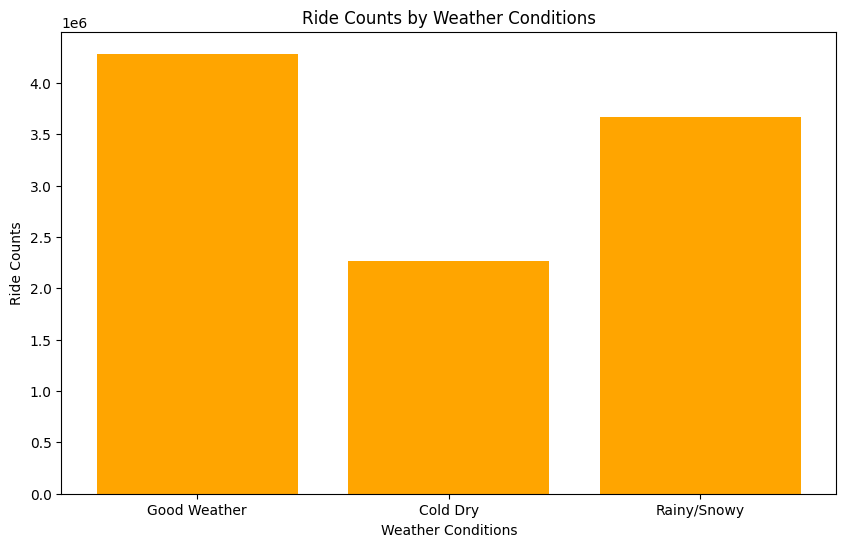

In [34]:
from pyspark.sql.functions import when

# Categorize weather conditions based on temperature and precipitation
condition_categories = when((col('temp') >= 15) & (col('precip') == 0), 'Good Weather') \
                    .when((col('temp') < 15) & (col('precip') == 0), 'Cold Dry') \
                    .when(col('precip') > 0, 'Rainy/Snowy') \
                    .otherwise('Other')

# Add the weather condition category to the DataFrame
spark_df = biketrips_weather_total.withColumn('weather_condition', condition_categories)

# Group by the new category and count the number of rides
weather_condition_counts = spark_df.groupBy('weather_condition').count()

# Collect the data
weather_data = weather_condition_counts.collect()

# Prepare the data for plotting
conditions = [row['weather_condition'] for row in weather_data]
counts = [row['count'] for row in weather_data]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(conditions, counts, color='orange')
plt.title('Ride Counts by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Ride Counts')
plt.show()


We can observe that it's more important for our clients the temperature rather than the precipitations

In [5]:
from pyspark.sql.functions import year, month, avg

# Extract year and month from 'started_at' for grouping
spark_df = biketrips_weather_total.withColumn("year", year("started_at"))
spark_df = spark_df.withColumn("month", month("started_at"))

# Group by year and month, then calculate the average ride duration
avg_duration_per_month = spark_df.groupBy("year", "month").agg(avg("duration").alias("avg_duration"))

# Sort the results by year and month
avg_duration_per_month = avg_duration_per_month.orderBy("year", "month")
# Collect the data
duration_data = avg_duration_per_month.collect()


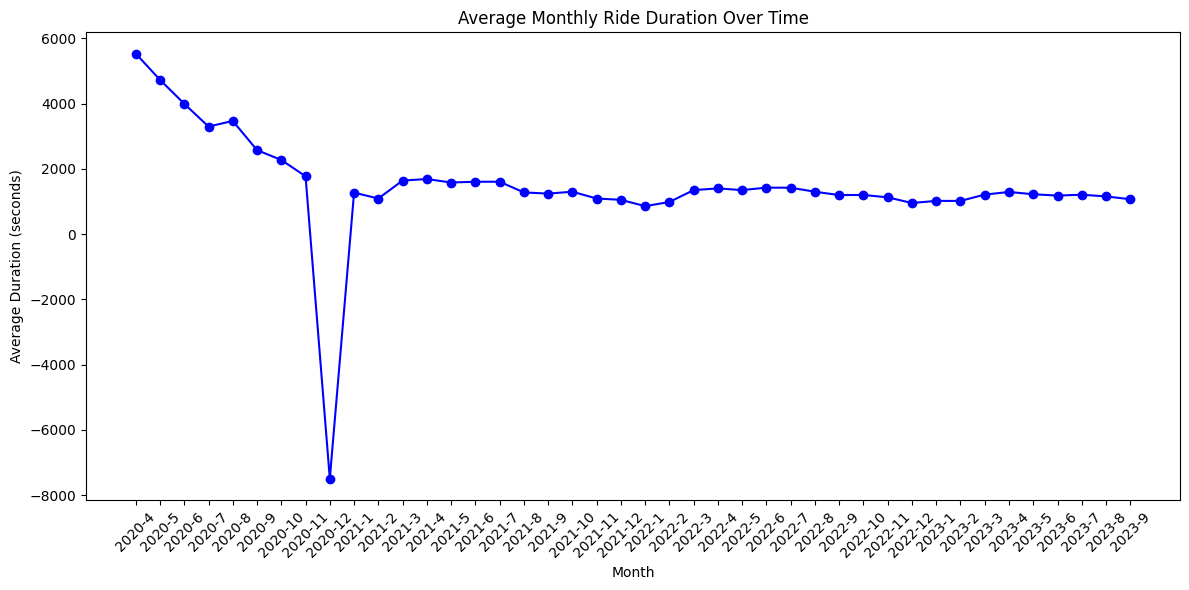

In [9]:
# Prepare data for plotting
months = [f"{row['year']}-{row['month']}" for row in duration_data]
avg_durations = [row['avg_duration'] for row in duration_data]

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(months, avg_durations, marker='o', linestyle='-', color='b')
plt.title('Average Monthly Ride Duration Over Time')
plt.xlabel('Month')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to fit all elements
plt.show()


we can observe that we have missing values in 2020-11

In [11]:
from pyspark.sql.functions import col

# Group by rideable type and member type, then count the number of rides
rideable_member_counts = spark_df.groupBy("rideable_type", "member_casual").count()

# Pivot the data to get separate columns for member and casual riders
pivoted_data = rideable_member_counts.groupBy("rideable_type").pivot("member_casual").sum("count")
# Collect the data
pivoted_data_collected = pivoted_data.collect()

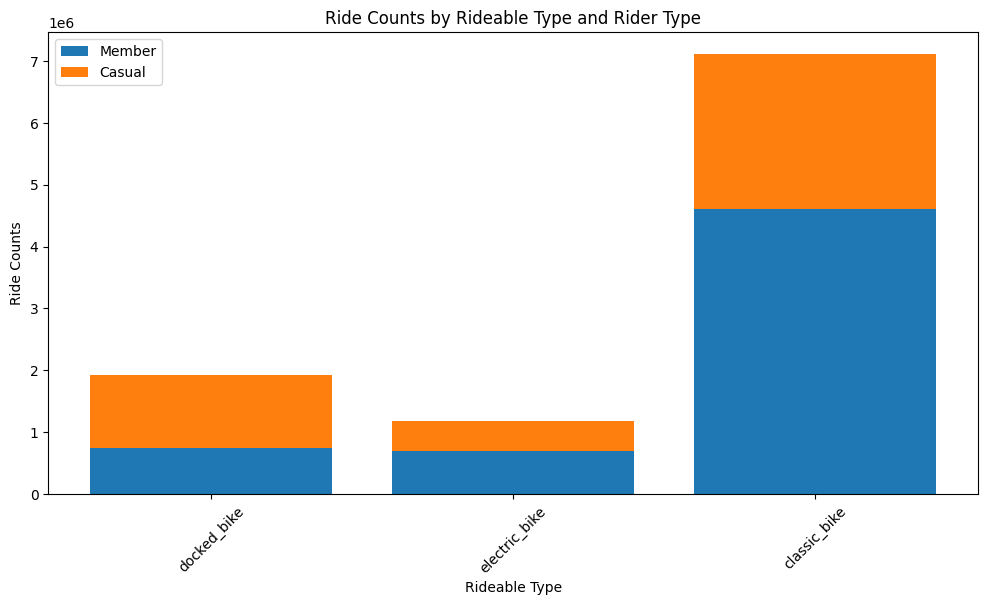

In [12]:
categories = [row['rideable_type'] for row in pivoted_data_collected]
member_counts = [row['member'] if 'member' in row else 0 for row in pivoted_data_collected]
casual_counts = [row['casual'] if 'casual' in row else 0 for row in pivoted_data_collected]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(categories, member_counts, label='Member')
plt.bar(categories, casual_counts, bottom=member_counts, label='Casual')
plt.title('Ride Counts by Rideable Type and Rider Type')
plt.xlabel('Rideable Type')
plt.ylabel('Ride Counts')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Classic bicycles are the most widely used and tend to be the most popular among associated users, while coupled bicycles are more common among occasional users.

In [13]:
spark_df.unpersist()

DataFrame[start_date: date, : int, ride_id: string, rideable_type: string, start_station_name: string, start_station_id: float, end_station_name: string, end_station_id: float, start_lat: float, start_lng: float, end_lat: float, end_lng: float, member_casual: string, started_at: timestamp, ended_at: timestamp, duration: bigint, tempmax: double, tempmin: double, temp: double, feelslikemax: double, feelslikemin: double, feelslike: double, dew: double, humidity: double, precip: double, precipprob: int, precipcover: double, snow: double, snowdepth: double, windspeed: double, winddir: double, sealevelpressure: double, cloudcover: double, visibility: double, solarradiation: double, solarenergy: double, uvindex: int, sunrise: timestamp, sunset: timestamp, moonphase: double, sunlight_hours: double, year: int, month: int]

In [15]:
from pyspark.sql.functions import hour, count

# Extract the hour from 'started_at'
spark_df = spark_df.withColumn("hour", hour("started_at"))

# Group by the hour and count the number of rides
hourly_rides = spark_df.groupBy("hour").count().orderBy("hour")
# Collect the data
hourly_rides_data = hourly_rides.collect()


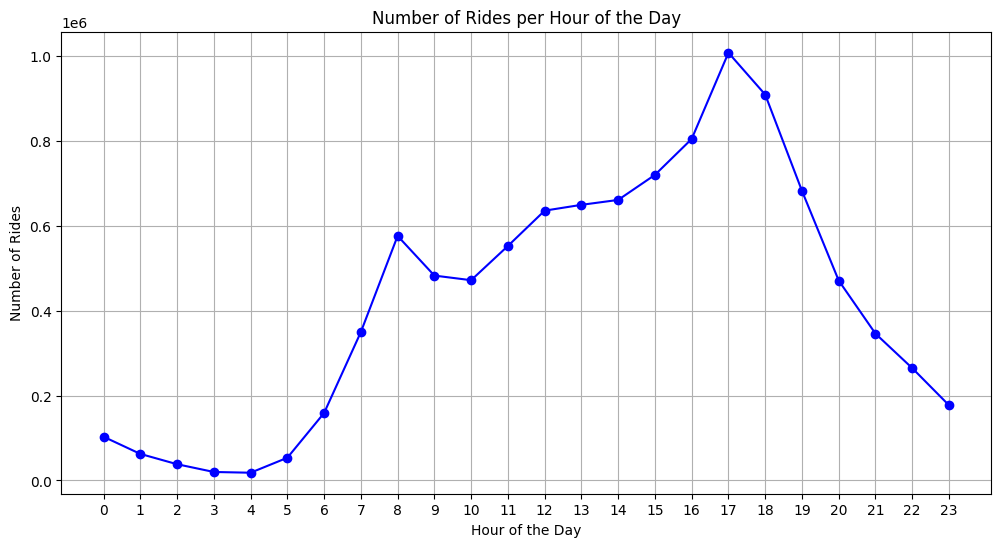

In [16]:
hours = [row['hour'] for row in hourly_rides_data]
ride_counts = [row['count'] for row in hourly_rides_data]

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(hours, ride_counts, marker='o', linestyle='-', color='b')
plt.title('Number of Rides per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))  # Set x-axis ticks to represent each hour of the day
plt.grid(True)
plt.show()


It is evident that commuting times to work are the ones with the peaks in bicycle commuting.